In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os as os
import tensorflow as ts
import tensorflow.keras as ks
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from mm_utils import calculate_score

In [2]:
def predict_wins(model, observation):
    """Make a prediction with the given model and return the number that was predicted"""
    pred = model.predict(observation.drop(columns=['Year', "Number of Tournament Wins"]).values.reshape(1,-1))
    num = pred[0].argmax()
    return num


def get_prediction_error(model, observation):
    """Return Predicted - Actual"""
    return predict_wins(model=model, observation=observation) - observation['Number of Tournament Wins'].values[0]


def get_submission_prediction(model, year_data):
    """Get top 10 predicted entries for a given year"""
    year_data['Predicted Wins'] = year_data.drop(columns=['Number of Tournament Wins', 'Year']).apply(lambda r: predict_wins(model, r), axis=1)
    return year_data


def get_submission_score(model, year_data):
    """Calculate and return score for top 10 predicted teams"""
    year_data = get_submission_prediction(model, year_data)
    year_data.sort_values(['Predicted Wins'], inplace=True, ascending=False)
    return calculate_score(year_data)
    

## Read in Data


In [3]:
# read in data
df = pd.read_csv("./processed_data/scaled_data.csv", index_col = 0)
# df = pd.read_csv("./processed_data/scaled_data.csv", index_col = 0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 0 to 477
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Cinderella                     478 non-null    float64
 1   Number of Tournament Wins      478 non-null    float64
 2   Game Count                     478 non-null    float64
 3   Wins                           478 non-null    float64
 4   Losses                         478 non-null    float64
 5   3-Pointers Made                478 non-null    float64
 6   3-Pointers Attempted           478 non-null    float64
 7   3-Point Percentage             478 non-null    float64
 8   Free Throws Made               478 non-null    float64
 9   Free Throws Attempted          478 non-null    float64
 10  Free Throw Percentage          478 non-null    float64
 11  Rebounds                       478 non-null    float64
 12  Opponent's Rebounds            478 non-null    flo

## Create Model

### Neural Network

- Several fully-connected layers
    - Try 256, 128, 64, 32, 7/11
    
- In `.fit()`, 
    - use `sample_weights` parameter to weight certain outputs as worth more than others.
    - use `validation_split` to automatically set aside data for validation
    - use `shuffle` for shuffling samples when training
    
- Using Dropout layers with 0.05 and 0.1
    - 0.1 after layer 256
    - 0.05 after layer 128
    - 0.05 after layer 64
    
- Using `relu` activation function for all except last layer. 
    - Tested with `relu` and `relu6`.
- Using `softmax` activation function on last layer to provide for probability distribution.

#### Output

##### Win-based

- 7 output nodes, predict number of wins (0-6)
    - Can look at problem as Classification
        - Use `y_dum` for predictions
        - Loss functions:
            - Categorical Cross Entropy: `categorical_crossentropy`
                - got around 99% accuracy at 300 epochs
            - KL Divergence: `kl_divergence`
                - got around 52% accuracy with `y` data at 300 epochs
                - got around 99% accuracy with `y_dum` data at 300 epochs
    - Can look at problem as Regression
        - Use `y` for predictions...maybe(?)
        - Loss functions:
            - Mean Squared Error: `mean_squared_error`
                - got around 25-30% accuracy with `y` at 300 epochs
                - got around 95% accuracy with `y_dum` data at 300 epochs
            - Sparse Categorical Cross Entropy: `sparse_categorical_crossentropy`
                - can only use `y` data
                - got around 99-100% accuracy at 300 epochs
            - Mean Absolute Error: `mean_absolute_error`
                - got around 66% accuracy with `y_dum` data at 300 epochs
                - got around 1% accuracy with `y` data at 300 epochs
- Must create function for evaluating how well the prediction worked for a given year
    - Evaluate score by selecting teams

##### Rank-based

- Find the optimal ranking of teams for each year
- 11 output nodes, predict which rank (0-10) the team should be placed in
- Use `optimal_data` for these predictions, likely even less plausible than using the number of wins for getting accurate models

#### Todo

- Use hyperparameterized, class-based optimization function, not just `adam` string.
- Try adding a layer of 512 nodes before layer of 256
- Use cross validation to ensure that the model is not overfitting
    - Train on pre-2021 data then use of 2021 to validate
- Use `sample_weights` hyperparameter to give more weight to higher win values
- Analyze output to see if model is under/overpredicting for misses
- ~~Create datasets for what the optimal team selections are.~~
- Tune Learning Rate (0.001 - 0.05)
- ~~Use early stopping if overfitting is an issue~~
- Somehow use scoring function as loss function
    - Could try using RL to select top 10 teams and figure out which top teams would be best


#### Misc Code

- Plot network with `ks.utils.plot_model(model, show_shapes=True)`
- Show summary with `model.summary()`

In [5]:
X = df[df['Year'] < 2021].drop(columns=['Number of Tournament Wins','Year'])
# y = df[['Cinderella','Number of Tournament Wins']]
y_dum = pd.get_dummies(df.loc[df['Year'] < 2021,'Number of Tournament Wins'])
y = df.loc[df['Year'] < 2021,'Number of Tournament Wins']

In [6]:
def create_model(X,y, layer_sizes: list, output_shape: int, epochs: int, weights: dict, learning_rate: float , loss_fn: str):
    """Create, fit, return a model based on the passed parameters"""
    # create model
    model = ks.Sequential()
    model.add(layers.Input(shape=X.shape[1], name='input'))
    
    for i in range(len(layer_sizes)):
        model.add(layers.Dense(layer_sizes[i], activation='relu', kernel_regularizer = ks.regularizers.l1(.0001)))
        model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(output_shape, activation='softmax'))
    
    # fit model
    opt = ks.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, metrics=['accuracy'], loss=loss_fn)
    res = model.fit(X,y, epochs = epochs, batch_size = 32, shuffle=True, class_weight=weights, verbose=0)
    
    # plot model
    plt.plot(res.epoch, res.history['accuracy'], label='accuracy')
    plt.plot(res.epoch, res.history['loss'], label='loss')
    # plt.plot(res.epoch, res.history['val_accuracy'], label='val accuracy')
    # plt.plot(res.epoch, res.history['val_loss'], label='val loss')
    plt.axhline(y=0)
    plt.axhline(y=1)
    plt.legend()
    plt.show()
    
    # return model
    return model
    

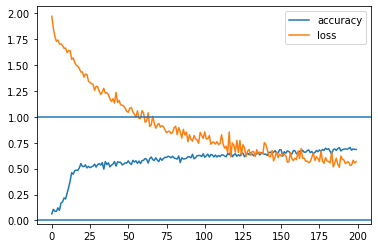

In [7]:
m = create_model(X,y,
             layer_sizes=[32,32,8],
             output_shape=7,
             epochs=200,
             learning_rate=0.001, 
             weights= {0:0.5,1:0.5,2:0.5,3:3,4:4,5:5,6:6},
             loss_fn='sparse_categorical_crossentropy')

In [8]:
get_submission_score(model=m, year_data=df[df['Year'] == 2021])

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


110.0

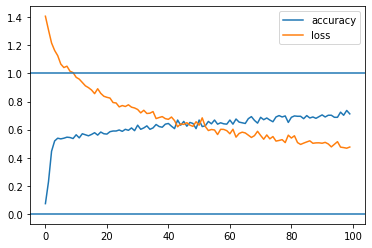

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 100, 'learning_rate': 0.001, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 154.0}


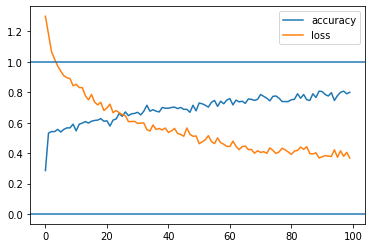

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 100, 'learning_rate': 0.002, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 140.0}


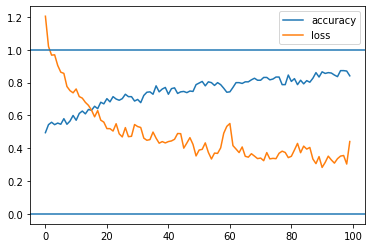

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 100, 'learning_rate': 0.01, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 160.0}


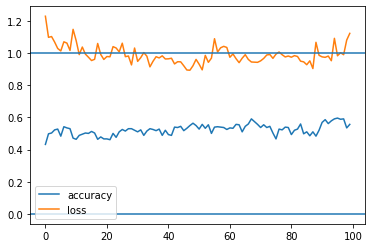

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 100, 'learning_rate': 0.05, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 151.0}


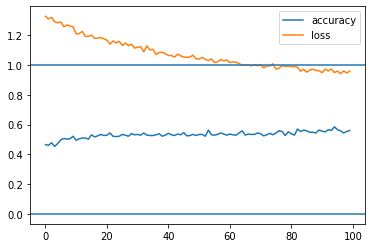

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 100, 'learning_rate': 0.0001, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 122.0}


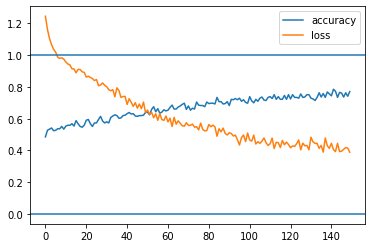

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 150, 'learning_rate': 0.001, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 129.0}


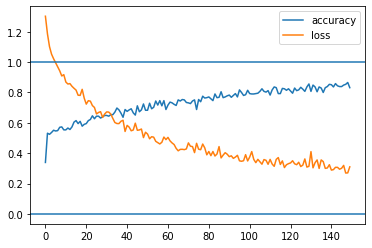

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 150, 'learning_rate': 0.002, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 145.0}


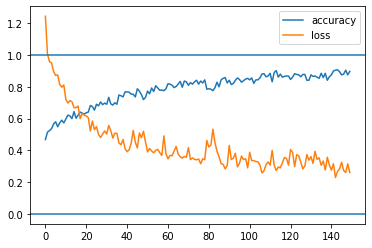

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 150, 'learning_rate': 0.01, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 107.0}


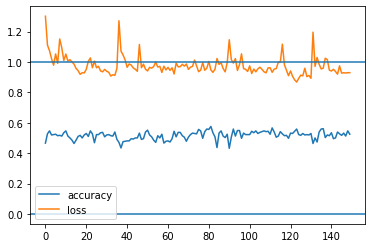

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 150, 'learning_rate': 0.05, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 191.0}


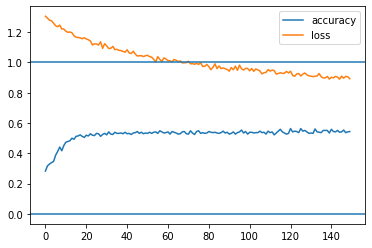

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 150, 'learning_rate': 0.0001, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 151.0}


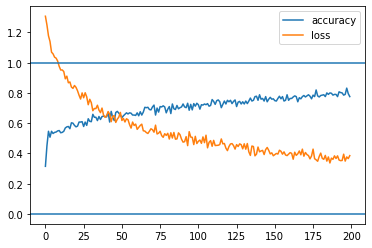

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 200, 'learning_rate': 0.001, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 158.0}


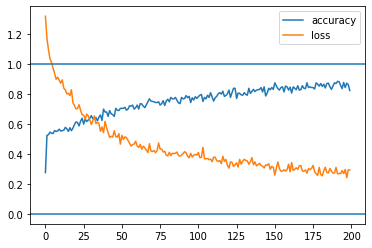

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 200, 'learning_rate': 0.002, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 154.0}


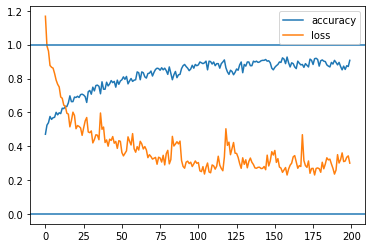

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 200, 'learning_rate': 0.01, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 105.0}


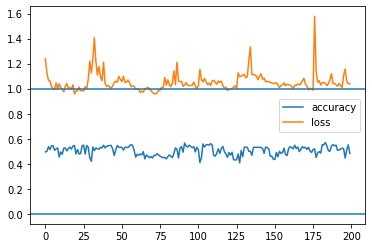

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 200, 'learning_rate': 0.05, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 175.0}


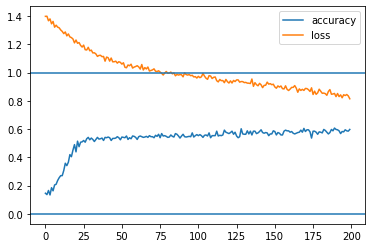

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [32, 32, 32], 'epochs': 200, 'learning_rate': 0.0001, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 155.0}


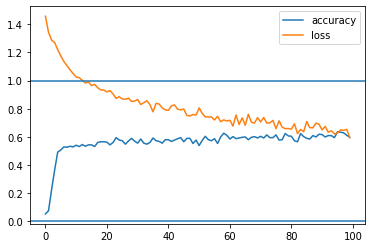

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 100, 'learning_rate': 0.001, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 162.0}


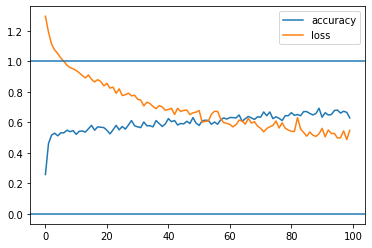

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 100, 'learning_rate': 0.002, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 145.0}


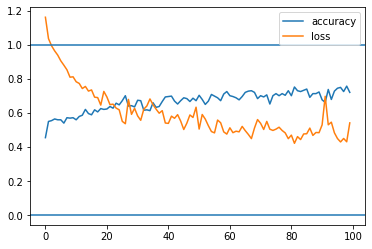

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 100, 'learning_rate': 0.01, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 124.0}


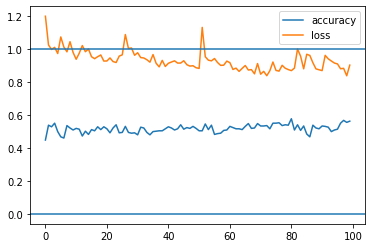

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 100, 'learning_rate': 0.05, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 159.0}


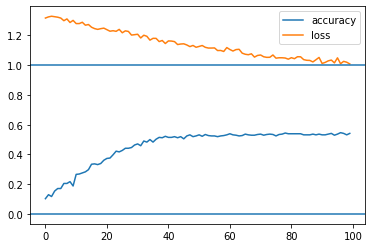

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 100, 'learning_rate': 0.0001, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 72.0}


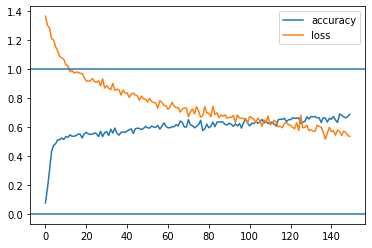

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 150, 'learning_rate': 0.001, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 128.0}


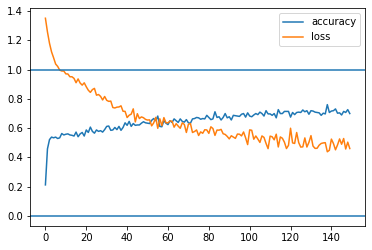

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 150, 'learning_rate': 0.002, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 89.0}


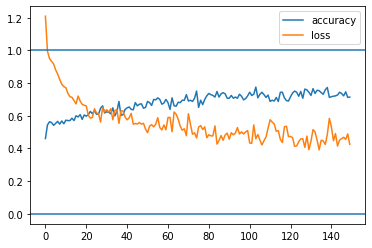

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 150, 'learning_rate': 0.01, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 161.0}


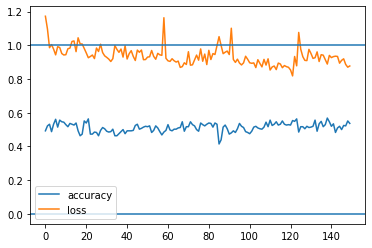

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 150, 'learning_rate': 0.05, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 187.0}


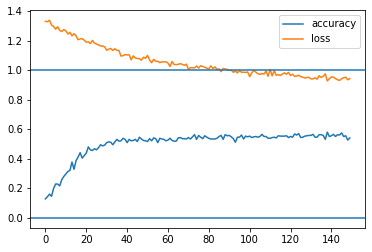

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 150, 'learning_rate': 0.0001, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 86.0}


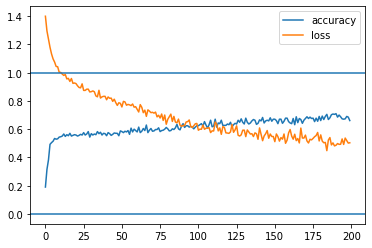

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 200, 'learning_rate': 0.001, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 182.0}


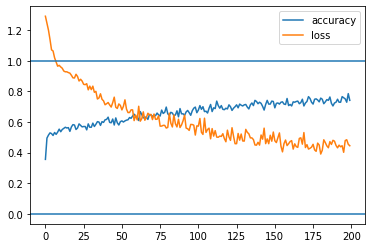

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 200, 'learning_rate': 0.002, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 118.0}


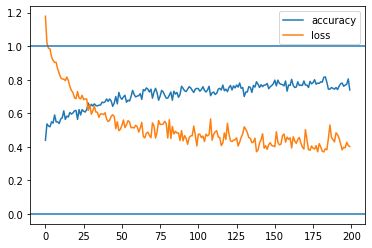

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 200, 'learning_rate': 0.01, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 159.0}


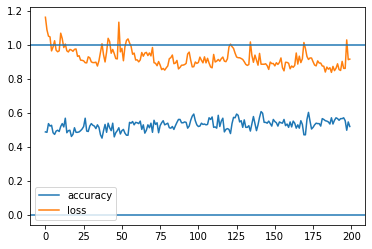

/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/lfwssl/MarchMadness/lib64/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'layer_sizes': [16, 32, 16], 'epochs': 200, 'learning_rate': 0.05, 'weight_0': 0.5, 'weight_1': 0.5, 'weight_2': 0.5, 'weight_3': 1, 'weight_4': 2, 'weight_5': 3, 'weight_6': 4, 'loss_fn': 'sparse_categorical_crossentropy', 'score': 137.0}


In [ ]:
res = pd.DataFrame(columns=['score','layer_sizes','epochs','learning_rate','weight_0','weight_1','weight_2','weight_3','weight_4','weight_5','weight_6','loss_fn'])

layer_sizes = [[32,32,32],[16,32,16],[64,32,16],
               [16,16,16],[32,32],[16,16,32],
              [16,8,16],[32,32,8],[32,16,8],[7,7,7,7],[8,7,7],
              [20,15,10,7],[20,16,12],[16,12,8],[20,16,12,8]]
epochs = [100,150,200]
learning_rate = [0.001, 0.002, 0.01, 0.05, 0.0001]
weights = {0:0.5, 1:0.5, 2:0.5, 3:1, 4:2, 5:3, 6:4}
loss_fn = "sparse_categorical_crossentropy"



for s in layer_sizes:
    for e in epochs:
        for l in learning_rate:
            current_attempt = {'layer_sizes':s,'epochs':e,'learning_rate':l,
                               'weight_0':weights[0],'weight_1':weights[1],'weight_2':weights[2],
                              'weight_3':weights[3],'weight_4':weights[4],'weight_5':weights[5],
                              'weight_6':weights[6],'loss_fn':loss_fn}
            m = create_model(X,y,layer_sizes=s,output_shape=7,epochs=e,learning_rate=l,weights=weights,loss_fn=loss_fn)
            current_attempt['score'] = get_submission_score(model=m, year_data=df[df['Year'] == 2021])
            res = res.append(current_attempt, ignore_index=True)
            print(current_attempt)
            


In [ ]:
res.to_csv("processed_data/model_results2.csv")

In [ ]:
res.sort_values('score', ascending=False)

## Validate Results

- Want to pick several Cinderella teams for bottom 4-6 predictions


## Save Model

- Save model to file along with relevant data